In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [3]:
# Set the working directory
os.chdir("C:/Users/mboldi/Documents/Teaching/UNIL/MachineLearning/Spring_2025/3 - Models/3.3 - Neural Networks/InClass")

In [4]:
# Load your dataframe 
df = pd.read_csv("bank.csv")

In [5]:
# Separate predictors from target, and convert target variable to numeric
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['deposit'])
X = df.drop('deposit', axis=1)

In [6]:
# Identify variable types
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Standardization and Encoding
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_transformer, numerical_cols),
    ('cat', cat_transformer, categorical_cols)
])

# Transform the datasets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [9]:
# Define the neural network architecture
model1 = tf.keras.Sequential([
   tf.keras.Input(shape=(X_train_preprocessed.shape[1],)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.Dense(1, activation='sigmoid')
])
# Define the improved neural network
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_preprocessed.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0005, l2=0.0005)),
    tf.keras.layers.Dropout(0.3),  # Dropout added
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0005, l2=0.0005)),
    tf.keras.layers.Dropout(0.3),  # Dropout added
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
# See model structure
model1.summary()
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,209 (55.50 KB)

 Trainable params: 14,209 (55.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,209 (55.50 KB)

 Trainable params: 14,209 (55.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the models with an adaptive learning rate
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='binary_crossentropy',
               metrics=['accuracy'])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [12]:
# Introduce early stopping (used for model 2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
# Set seed for Python's built-in random module
random.seed(145)
np.random.seed(345)
tf.random.set_seed(765)

# Train the models
history1 = model1.fit(X_train_preprocessed, y_train, epochs=100, batch_size=32,
                      validation_data=(X_test_preprocessed, y_test),
                      verbose=1)
history2 = model2.fit(X_train_preprocessed, y_train, epochs=100, batch_size=32,
                      validation_data=(X_test_preprocessed, y_test),
                      callbacks=[early_stopping], verbose=1)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8532 - loss: 0.3908 - val_accuracy: 0.8862 - val_loss: 0.2561
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9065 - loss: 0.2295 - val_accuracy: 0.8928 - val_loss: 0.2420
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9144 - loss: 0.2110 - val_accuracy: 0.8961 - val_loss: 0.2354
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9226 - loss: 0.1992 - val_accuracy: 0.8961 - val_loss: 0.2329
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.1900 - val_accuracy: 0.8983 - val_loss: 0.2318
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9296 - loss: 0.1821 - val_accuracy: 0.8928 - val_loss: 0.2309
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9294 - loss: 0.1744 - val_accuracy: 0.8917 - val_loss: 0.2306
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9326 - loss: 0.1662 - val_accu

In [14]:
# Evaluate the models
test_loss_1, test_acc_1 = model1.evaluate(X_test_preprocessed, y_test, verbose=0)
train_loss_1, train_acc_1 = model1.evaluate(X_train_preprocessed, y_train, verbose=0)
print(f'Test accuracy model 1: {test_acc_1:.4f}')
print(f'Training accuracy model 1: {train_acc_1:.4f}')

test_loss_2, test_acc_2 = model2.evaluate(X_test_preprocessed, y_test, verbose=0)
train_loss_2, train_acc_2 = model2.evaluate(X_train_preprocessed, y_train, verbose=0)
print(f'Test accuracy model 2: {test_acc_2:.4f}')
print(f'Training accuracy model 2: {train_acc_2:.4f}')

Test accuracy model 1: 0.8796
Training accuracy model 1: 0.9997
Test accuracy model 2: 0.9017
Training accuracy model 2: 0.9176


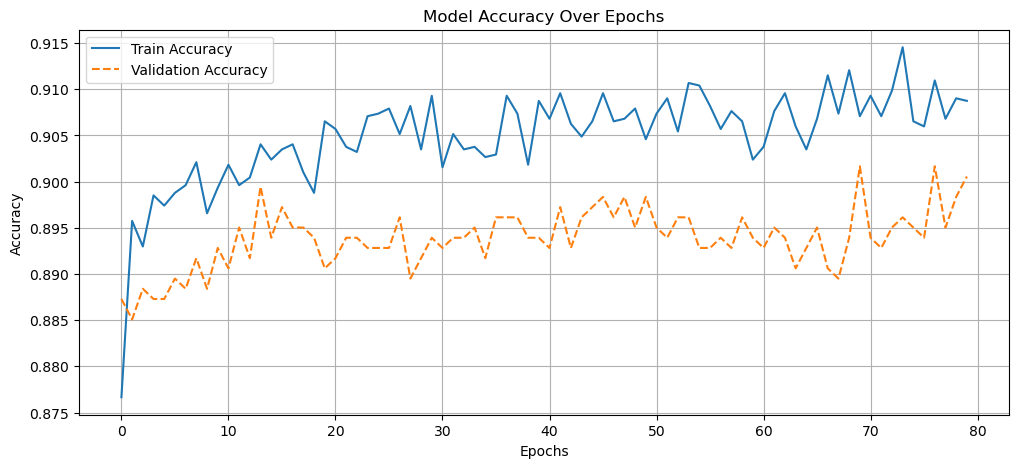

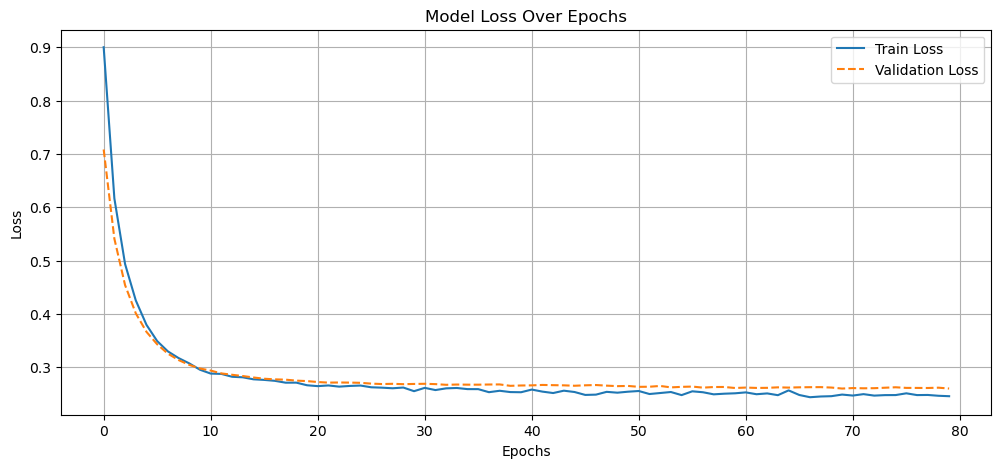

In [17]:
# Extract accuracy and loss history
history_dict = history2.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()